<a href="https://colab.research.google.com/github/NithderP/NithderP/blob/main/Ch5_DeepWalk_and_Node2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implement DeepWalk to find Similar Wikipedia Pages

## Step 1: Create a Wikipedia graph using a tool called Seealsology

## Step 2: Once the graph is ready, download the graph data as a TSV file from Seealsology.

## Step 3: Import the required python Libraries

In [ ]:
import networkx as nx
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from sklearn.decomposition import PCA
from gensim.models import Word2Vec

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

## Step 4: Load dataset

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive') # needed to read file on our google drive
df = pd.read_csv("/content/drive/MyDrive/Teaching/Colab Notebooks/Graph Analytics/Tutorials/Datasets/wikipedia_graph.tsv", sep = "\t")
df.head()

## Step 5: Construct the graph.

In [ ]:
G = nx.from_pandas_edgelist(df, "source", "target", edge_attr=True, create_using=nx.Graph())

## Step 6: Random Walk

In [ ]:
def get_randomwalk(node, path_length):

    random_walk = [node]

    for i in range(path_length-1):
        temp = list(G.neighbors(node))
        temp = list(set(temp) - set(random_walk))
        if len(temp) == 0:
            break

        random_node = random.choice(temp)
        random_walk.append(random_node)
        node = random_node

    return random_walk

## Step 7: Capture the random walks for all the nodes in our dataset

In [ ]:
# get list of all nodes from the graph
all_nodes = list(G.nodes())

random_walks = []
for n in tqdm(all_nodes):
    for i in range(5):
        random_walks.append(get_randomwalk(n,10))

# count of sequences
len(random_walks)

100%|██████████| 2172/2172 [00:00<00:00, 15359.24it/s]


10860

## Step 8: DeepWalk - train the skip-gram model with the random walks

In [ ]:
# train skip-gram (word2vec) model
model = Word2Vec(window = 4, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(random_walks, progress_per=2)

model.train(random_walks, total_examples = model.corpus_count, epochs=20, report_delay=1)

(938417, 963300)

# Step 9: Test the code.

Let’s find out the most similar pages to “space tourism”.

In [ ]:
model.wv.similar_by_word('space tourism')

Let's see how well our node embeddings capture the similarity between different nodes. Handpick a few nodes from the graph and plot them on a 2-dimensional space.

In [ ]:
terms = ['lunar escape systems','soviet moonshot', 'soyuz 7k-l1',
         'moon landing','space food', 'food systems on space exploration missions',
         'meal, ready-to-eat','space law', 'metalaw', 'moon treaty',
         'legal aspects of computing','astronaut training', 'reduced-gravity aircraft',
         'space adaptation syndrome', 'micro-g environment']

In [ ]:
def plot_nodes(word_list):
    X = model.wv[word_list]

    # reduce dimensions to 2
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)


    plt.figure(figsize=(12,9))
    # create a scatter plot of the projection
    plt.scatter(result[:, 0], result[:, 1])
    for i, word in enumerate(word_list):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))

    plt.show()

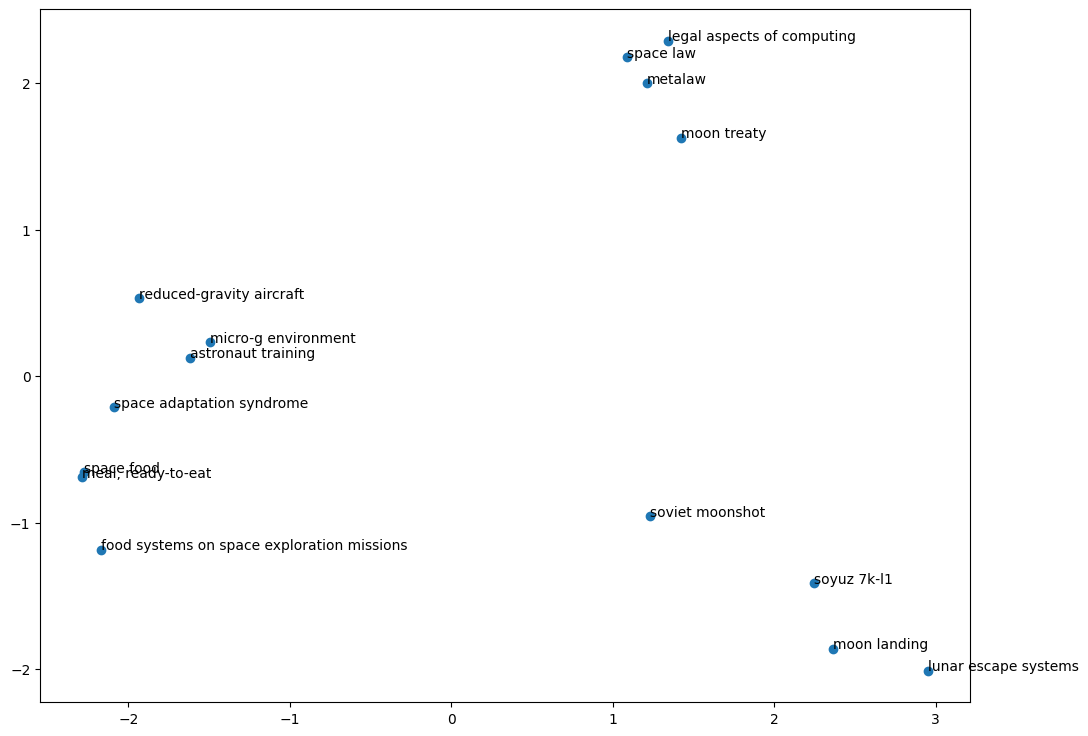

In [ ]:
plot_nodes(terms)

# Node2vec

In [ ]:
pip install node2vec

In [ ]:
import networkx as nx
from node2vec import Node2Vec

# Initialize Node2Vec with the graph G
node2vec = Node2Vec(G, dimensions=32, walk_length=10, num_walks=50, workers=4)

# Generate random walks
walks = node2vec.walks

# Train the Node2Vec model
model_n2v = node2vec.fit(window=10, min_count=1, batch_words=4)

# Get node embeddings
node_embeddings = {node: model_n2v.wv[node] for node in G.nodes()}


Computing transition probabilities:   0%|          | 0/2172 [00:00<?, ?it/s]

In [ ]:
def plot_nodes_n2v(word_list):
    X = model_n2v.wv[word_list]

    # reduce dimensions to 2
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)


    plt.figure(figsize=(12,9))
    # create a scatter plot of the projection
    plt.scatter(result[:, 0], result[:, 1])
    for i, word in enumerate(word_list):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))

    plt.show()

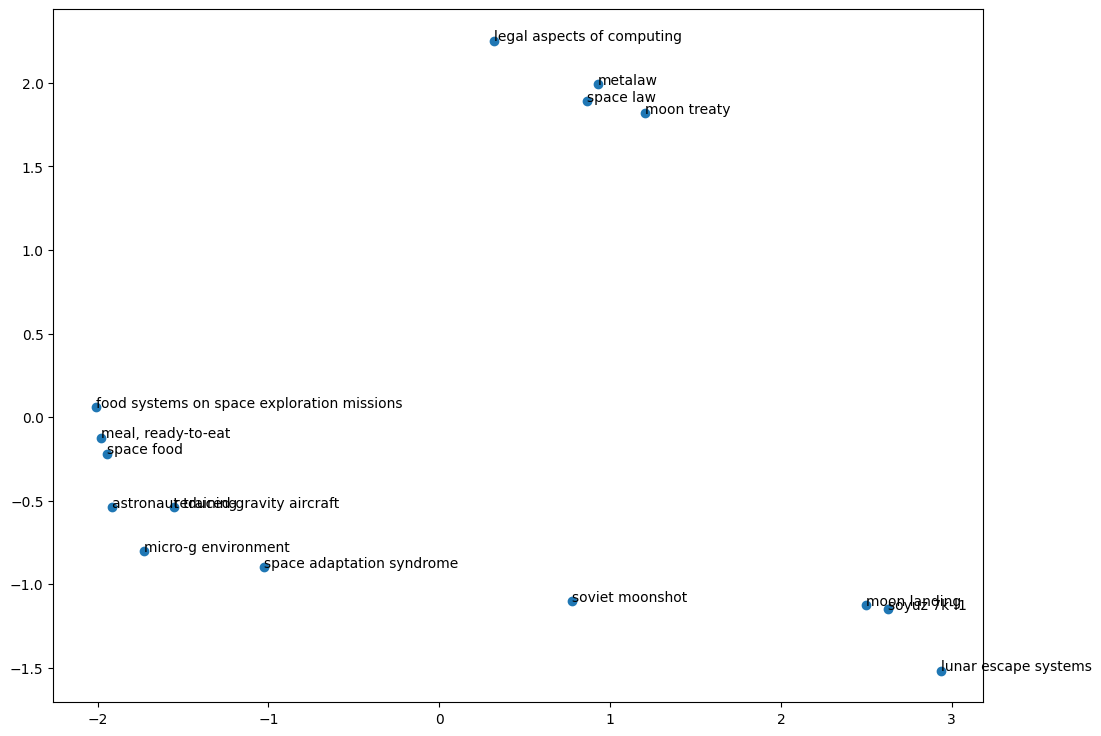

In [ ]:
plot_nodes_n2v(terms)